In [20]:
import pandas as pd
import numpy as np
import sklearn
import itertools
import matplotlib.pyplot as plt
from pathlib import Path

In [21]:
def filter_df(df_raw):
    new_columns = df_raw.columns + " " + df_raw.iloc[0] + " " + df_raw.iloc[1]
    df_filt = df_raw.copy()
    df_filt.columns = new_columns
    df_filt = df_filt.drop([0, 1]).reset_index(drop=True)
    df_filt.head()
    df = df_filt.apply(pd.to_numeric)
    return df

Node 83 is on the top (= Node 332)

Node 156 is on the side (= Node 359)

In [22]:
data_folder = "Data/"
health_status = ["imperfect","perfect"]
structure_status = ["Long","Short"]
force_status = ["1","2"]
combinations = list(itertools.product(health_status,structure_status,force_status))
name_assignment = {
    "Unnamed: 0 X 0.": "time",
    "_U:Magnitude PI: PART-1-1 N: 83 0.": "mag_top",
    "_U:Magnitude PI:.1 PART-1-1 N: 156 0.": "mag_side",
    "_U:U1 PI: PART-1- 1 N: top 0.": "x_top",
    "_U:U2 PI: PART-1- 1 N: top 0.": "y_top",
    "_U:U3 PI: PART-1- 1 N: top 0.": "z_top",
    "_U:U1 PI: PART-1-.1 1 N: side 0.": "x_side",
    "_U:U2 PI: PART-1-.1 1 N: side 0.": "y_side",
    "_U:U3 PI: PART-1-.1 1 N: side 0.": "z_side",
}
def get_df(health, structure, force):
    folder_name = f"class_{1 if health=='imperfect' else 0}_{health}_structure"
    filename = f"Displacement_{structure}_Structure_{force}MN_Force.rpt"
    file = Path(folder_name) / filename
    df = pd.read_fwf(data_folder+str(file))
    df = filter_df(df)
    df.columns = name_assignment.values()

    # Add feature as column
    if health == "imperfect":
        df["health"] = pd.Series(np.zeros_like(df.index))
    elif health == "perfect":
        df["health"] = pd.Series(np.ones_like(df.index))

    if structure == "Long":
        df["structure"] = pd.Series(np.ones_like(df.index))
    elif structure == "Short":
        df["structure"] = pd.Series(np.zeros_like(df.index))
    
    df["force"] = pd.Series(int(force)*np.ones_like(df.index))

    return df

dfs = []
for type in combinations:
    df = get_df(*type)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [23]:
pd.Series(range(len(df)))

0        0
1        1
2        2
3        3
4        4
      ... 
795    795
796    796
797    797
798    798
799    799
Length: 800, dtype: int64

# Inspect

<Axes: xlabel='time', ylabel='health'>

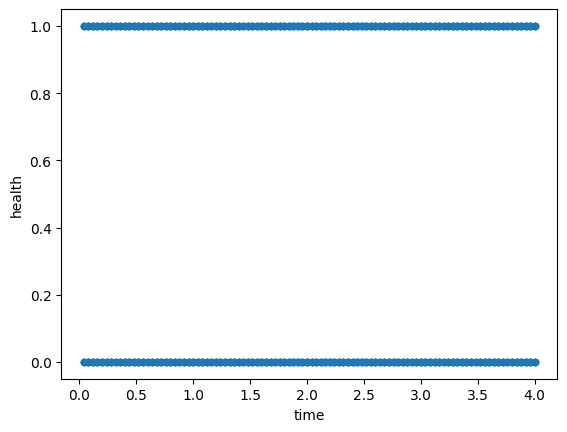

In [24]:
df.plot(x="time", y="health", kind="scatter")

<Axes: xlabel='time', ylabel='mag_top'>

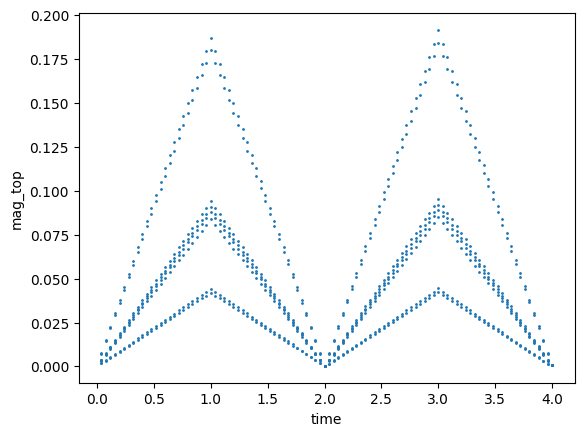

In [25]:
df.plot(x="time", y="mag_top", kind="scatter", s=1)

# Train-Test Split

In [26]:
X_raw, y_raw = df.drop(columns=["health"]), df["health"]
X_train_raw, X_test_raw, y_train, y_test = sklearn.model_selection.train_test_split(
    X_raw, y_raw, test_size = 0.1, random_state = 0, shuffle=True,
)

# Data standardization

In [27]:
continuous_x_columns = ["time","mag_top", "mag_side", "x_top", "y_top", "z_top", "x_side", "y_side", "z_side"]
binary_x_columns = ["structure","force"]
x_columns = continuous_x_columns+binary_x_columns
y_column = "health"

In [28]:
scaler = sklearn.preprocessing.StandardScaler()

scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [29]:
train_indices = set(X_train_raw.index)
test_indices = set(X_test_raw.index)
overlap = train_indices.intersection(test_indices)
print(f"Number of overlapping indices: {len(overlap)}")
if len(overlap) > 0:
    print("Warning: Train and test sets are not independent!")
else:
    print("Train and test sets are independent.")

Number of overlapping indices: 0
Train and test sets are independent.


In [30]:
overlap_time = set(X_train_raw["time"]).intersection(set(X_test_raw["time"]))
print(f"Number of overlapping 'time' values: {len(overlap_time)}")

Number of overlapping 'time' values: 57


# Logistic Regression

In [31]:
model = sklearn.linear_model.LogisticRegression(random_state=0)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [32]:
model.score(X_test, y_test), model.score(X_train, y_train)

(0.575, 0.5597222222222222)

Question: Why is score on test better than on train?

# Support Vector Machine

In [33]:
model = sklearn.svm.SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
model.score(X_test, y_test), model.score(X_train, y_train)

(0.925, 0.9375)

# Decision tree

In [35]:
model = sklearn.tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [36]:
model.score(X_test, y_test), model.score(X_train, y_train)

(1.0, 1.0)

In [37]:
acc_df = pd.DataFrame(columns=['col', 'acc'], index=range(len(x_columns)))

for i, c in enumerate(x_columns):

    model.fit(X_train[:,i][:, None], y_train)

    y_pred = model.predict(X_test[:,i][:, None])
    acc_df.iloc[i] = [c, sklearn.metrics.accuracy_score(y_test, y_pred)*100]

acc_df.sort_values('acc',ascending=False)


,col,acc
4,y_top,93.75
3,x_top,90.0
1,mag_top,88.75
2,mag_side,87.5
5,z_top,76.25
6,x_side,61.25
7,y_side,60.0
8,z_side,56.25
9,structure,43.75
10,force,43.75


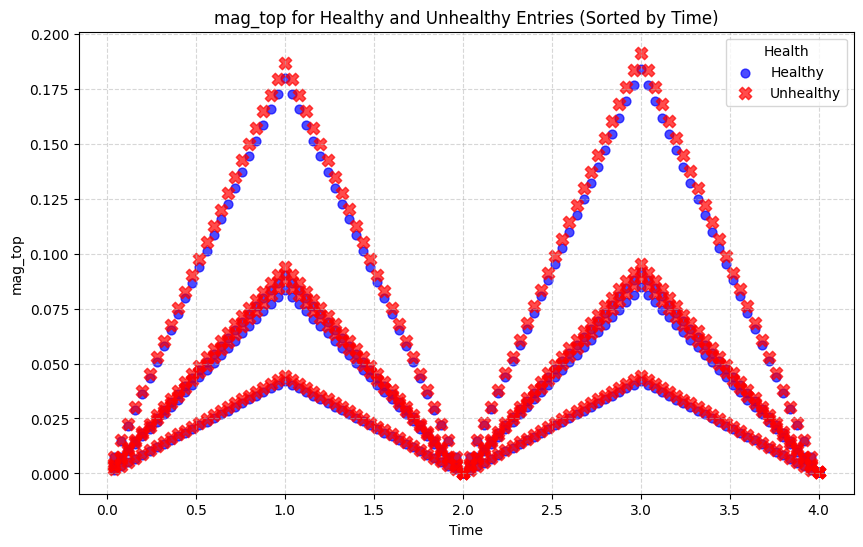

In [38]:
df_sorted = df.sort_values("time")
plt.figure(figsize=(10,6))

healthy = df_sorted[df_sorted["health"] == 1]
unhealthy = df_sorted[df_sorted["health"] == 0]

plt.scatter(
    healthy["time"], healthy["mag_top"],
    c="blue", marker="o", s=40, alpha=0.7, label="Healthy"
)
plt.scatter(
    unhealthy["time"], unhealthy["mag_top"],
    c="red", marker="X", s=80, alpha=0.7, label="Unhealthy"
)

plt.xlabel("Time")
plt.ylabel("mag_top")
plt.title("mag_top for Healthy and Unhealthy Entries (Sorted by Time)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Health")
plt.show()